# AMAZON REVIEWS 
# Sentiment Analysis With RoBERTa And Neural Models
Import Libraries


In [6]:
import re
import numpy as np
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaModel

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-01-07 17:59:36.736408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 17:59:41.443279: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-01-07 17:59:41.443445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

# 1. Data Loading & Preprocessing

In [7]:
data = pd.read_csv('Amazon_Unlocked_Mobile.csv')

# Create binary sentiment labels: 1 (positive) for rating >= 4, 0 (negative) for rating <= 2
def sentiment_label(rating):
    if rating >= 4:
        return 1
    elif rating <= 2:
        return 0
    else:
        return None

data['Sentiment'] = data['Rating'].apply(sentiment_label)
data = data.dropna(subset=['Sentiment', 'Reviews'])  # remove rows with missing sentiment or reviews

# Text cleaning: lowercase, remove non-alphabetic, strip extra spaces
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['Cleaned_Reviews'] = data['Reviews'].apply(clean_text)

# Balance the dataset (equal # of positive/negative)
positive = data[data['Sentiment'] == 1]
negative = data[data['Sentiment'] == 0]

if len(positive) > len(negative):
    positive = positive.sample(n=len(negative), random_state=42)
else:
    negative = negative.sample(n=len(positive), random_state=42)

data = pd.concat([positive, negative]).sample(frac=1, random_state=42).reset_index(drop=True)

# 2. RoBERTa Embedding Extraction (single [CLS] vector)

In [8]:
# Check if a GPU is available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base').to(device)
model.eval()

def get_roberta_embeddings(texts, batch_size=32, max_length=128):
    all_embeddings = []

    for start_idx in range(0, len(texts), batch_size):
        batch_texts = texts[start_idx:start_idx + batch_size]
        
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            # [CLS] embedding is at index 0 along sequence dimension
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        
        all_embeddings.append(batch_embeddings.cpu().numpy())

    return np.concatenate(all_embeddings, axis=0)

reviews_list = data['Cleaned_Reviews'].tolist()
embeddings = get_roberta_embeddings(reviews_list, batch_size=32, max_length=128)
sentiments = data['Sentiment'].values

print("Embeddings shape:", embeddings.shape)  # e.g. (num_samples, 768)

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embeddings shape: (194118, 768)


# 3. Train-Test Split 

In [9]:
X_full_train, X_test, y_full_train, y_test = train_test_split(
    embeddings,
    sentiments,
    test_size=0.2,
    random_state=42
)

 We will do cross-validation + hyperparam tuning on X_full_train / y_full_train,
 then the final selected model will be tested on X_test / y_test.

 For RNN-based networks, we need a 3D shape: (batch_size, timesteps=1, features).
 
 We'll create them after we pick hyperparameters.
 # 4. Model Building Functions

In [11]:
def create_feedforward_model(input_dim, hp):
    """
    Creates a feed-forward (Dense) model.
    :param input_dim: Dimension of input (e.g., 768)
    :param hp: dict with hyperparameters, e.g.:
               {
                 'dense_units': 256,
                 'dropout': 0.3,
                 'lr': 1e-4
               }
    """
    model = Sequential()
    model.add(Dense(hp['dense_units'], activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(hp['dropout']))
    
    # Additional hidden layer (fixed size or could be tuned)
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(hp['dropout']))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=hp['lr'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_shape, hp):
    """
    Creates an LSTM model with a single time dimension (1).
    :param input_shape: (timesteps=1, features=768)
    :param hp: dict with hyperparameters
    """
    model = Sequential()
    model.add(LSTM(hp['lstm_units'], return_sequences=True, input_shape=input_shape))
    model.add(Dropout(hp['dropout']))
    model.add(LSTM(64))  # second LSTM layer fixed at 64 for demonstration
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(hp['dropout']))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=hp['lr'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(input_shape, hp):
    """
    Creates a GRU model (similar structure to LSTM).
    """
    model = Sequential()
    model.add(GRU(hp['gru_units'], return_sequences=True, input_shape=input_shape))
    model.add(Dropout(hp['dropout']))
    model.add(GRU(64))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(hp['dropout']))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=hp['lr'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_bidirectional_lstm_model(input_shape, hp):
    """
    Creates a Bidirectional LSTM model.
    """
    model = Sequential()
    model.add(Bidirectional(LSTM(hp['bilstm_units'], return_sequences=True), input_shape=input_shape))
    model.add(Dropout(hp['dropout']))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(hp['dropout']))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=hp['lr'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 5. Hyperparameter Grids

In [12]:
hyperparams_dict = {
    'Feedforward': {
        'dense_units': [128, 256],
        'dropout': [0.3, 0.4],
        'lr': [1e-4, 1e-3]
    },
    'LSTM': {
        'lstm_units': [64, 128],
        'dropout': [0.3, 0.4],
        'lr': [1e-4, 1e-3]
    },
    'GRU': {
        'gru_units': [64, 128],
        'dropout': [0.3, 0.4],
        'lr': [1e-4, 1e-3]
    },
    'Bidirectional LSTM': {
        'bilstm_units': [64, 128],
        'dropout': [0.3, 0.4],
        'lr': [1e-4, 1e-3]
    }
}

# Model creation mapping
model_creators = {
    'Feedforward': create_feedforward_model,
    'LSTM': create_lstm_model,
    'GRU': create_gru_model,
    'Bidirectional LSTM': create_bidirectional_lstm_model
}

# 6. Cross Validation for Hyperparameter Tuning

In [13]:
def cross_validate_model(model_name, hyperparams, X_train, y_train, n_splits=3, epochs=5, batch_size=32):
    """
    Performs cross-validation on the given (X_train, y_train) with specified hyperparams.
    Returns average validation accuracy across folds.
    """
    # RNNs need 3D input; feedforward needs 2D.
    if model_name == 'Feedforward':
        X_cv = X_train  # 2D
    else:
        # Reshape to 3D (batch_size, 1, features)
        X_cv = np.expand_dims(X_train, axis=1)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, val_idx in kf.split(X_cv, y_train):
        X_fold_train, X_fold_val = X_cv[train_idx], X_cv[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Build model
        create_fn = model_creators[model_name]
        
        # For feedforward, pass input_dim as integer
        if model_name == 'Feedforward':
            input_dim = X_fold_train.shape[1]
            model_cv = create_fn(input_dim, hyperparams)
        else:
            # RNN shape: (1, features)
            features_dim = X_fold_train.shape[2]
            model_cv = create_fn((1, features_dim), hyperparams)
        
        # Train with early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
        
        model_cv.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Evaluate
        val_preds = (model_cv.predict(X_fold_val).ravel() > 0.5).astype(int)
        acc = accuracy_score(y_fold_val, val_preds)
        accuracies.append(acc)
    
    return np.mean(accuracies)

 We'll store the best hyperparams for each architecture

In [14]:
best_hyperparams = {}
best_cv_score = {}

for model_name, param_grid in hyperparams_dict.items():
    print(f"\n=== Tuning {model_name} ===")
    best_score = 0.0
    best_params = None
    
    # Manual grid search
    from itertools import product
    
    # Create a list of all possible combinations
    keys = list(param_grid.keys())  # e.g. ['dense_units', 'dropout', 'lr']
    for values in product(*param_grid.values()):
        # Create a dict of param_name -> chosen_value
        hp = dict(zip(keys, values))
        
        # Cross-validate
        cv_acc = cross_validate_model(
            model_name=model_name,
            hyperparams=hp,
            X_train=X_full_train,
            y_train=y_full_train,
            n_splits=3,
            epochs=5,       # fewer epochs for CV
            batch_size=32
        )
        
        if cv_acc > best_score:
            best_score = cv_acc
            best_params = hp
    
    best_hyperparams[model_name] = best_params
    best_cv_score[model_name] = best_score
    print(f"Best CV accuracy = {best_score:.4f} with params = {best_params}")


=== Tuning Feedforward ===


2025-01-07 18:18:59.981010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-07 18:19:00.333722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-07 18:19:00.335231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-07 18:19:00.338513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

1618/1618 [==============================] - 2s 1ms/step
Best CV accuracy = 0.9320 with params = {'dense_units': 128, 'dropout': 0.3, 'lr': 0.001}

=== Tuning LSTM ===


2025-01-07 18:40:29.147326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900


1618/1618 [==============================] - 4s 2ms/step
Best CV accuracy = 0.9289 with params = {'lstm_units': 64, 'dropout': 0.4, 'lr': 0.001}

=== Tuning GRU ===
1618/1618 [==============================] - 4s 2ms/step
Best CV accuracy = 0.9296 with params = {'gru_units': 64, 'dropout': 0.4, 'lr': 0.001}

=== Tuning Bidirectional LSTM ===
1618/1618 [==============================] - 6s 3ms/step
Best CV accuracy = 0.9310 with params = {'bilstm_units': 128, 'dropout': 0.3, 'lr': 0.001}


# 7. Retrain Each Model on the Entire Training Set with Best Hyperparams
Then Evaluate on the Test Set

In [15]:
final_results = {}  # store final metrics, predictions, etc.

for model_name, hp in best_hyperparams.items():
    print(f"\n=== Final Training for {model_name} with hyperparams {hp} ===")
    
    # RNN or feedforward shape
    if model_name == 'Feedforward':
        X_train_final = X_full_train
        X_test_final = X_test
        input_dim = X_train_final.shape[1]
        final_model = model_creators[model_name](input_dim, hp)
    else:
        X_train_final = np.expand_dims(X_full_train, axis=1)
        X_test_final = np.expand_dims(X_test, axis=1)
        features_dim = X_train_final.shape[2]
        final_model = model_creators[model_name]((1, features_dim), hp)
    
    # We'll do a bit longer training now
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = final_model.fit(
        X_train_final, y_full_train,
        validation_split=0.2,
        epochs=10,        # can go higher now
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    y_pred_proba = final_model.predict(X_test_final).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    test_acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    final_results[model_name] = {
        'model': final_model,
        'history': history.history,
        'test_accuracy': test_acc,
        'report': report,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'hyperparams': hp
    }
    
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} Classification Report:\n{report}")


=== Final Training for Feedforward with hyperparams {'dense_units': 128, 'dropout': 0.3, 'lr': 0.001} ===
Epoch 1/10
3883/3883 [==============================] - 13s 3ms/step - loss: 0.2426 - accuracy: 0.9049 - val_loss: 0.2084 - val_accuracy: 0.9235
Epoch 2/10
3883/3883 [==============================] - 12s 3ms/step - loss: 0.2091 - accuracy: 0.9206 - val_loss: 0.1909 - val_accuracy: 0.9288
Epoch 3/10
3883/3883 [==============================] - 12s 3ms/step - loss: 0.2011 - accuracy: 0.9240 - val_loss: 0.1990 - val_accuracy: 0.9234
Epoch 4/10
3883/3883 [==============================] - 12s 3ms/step - loss: 0.1964 - accuracy: 0.9259 - val_loss: 0.1818 - val_accuracy: 0.9326
Epoch 5/10
3883/3883 [==============================] - 12s 3ms/step - loss: 0.1932 - accuracy: 0.9277 - val_loss: 0.1806 - val_accuracy: 0.9331
Epoch 6/10
3883/3883 [==============================] - 12s 3ms/step - loss: 0.1894 - accuracy: 0.9293 - val_loss: 0.1836 - val_accuracy: 0.9314
Epoch 7/10
3883/3883 [=

# 8. Visualizations (Loss, Accuracy, Confusion Matrices, ROC/AUC)
We'll compare final models on the test set.

A) Training vs. Validation Accuracy (for each final model)

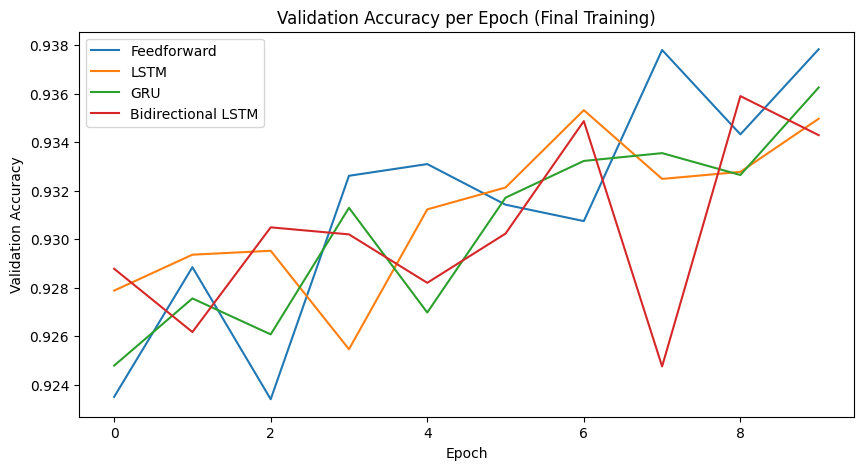

In [16]:
plt.figure(figsize=(10, 5))
for model_name, info in final_results.items():
    hist = info['history']
    if 'val_accuracy' in hist:
        plt.plot(hist['val_accuracy'], label=model_name)
plt.title('Validation Accuracy per Epoch (Final Training)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

B) Training vs. Validation Loss

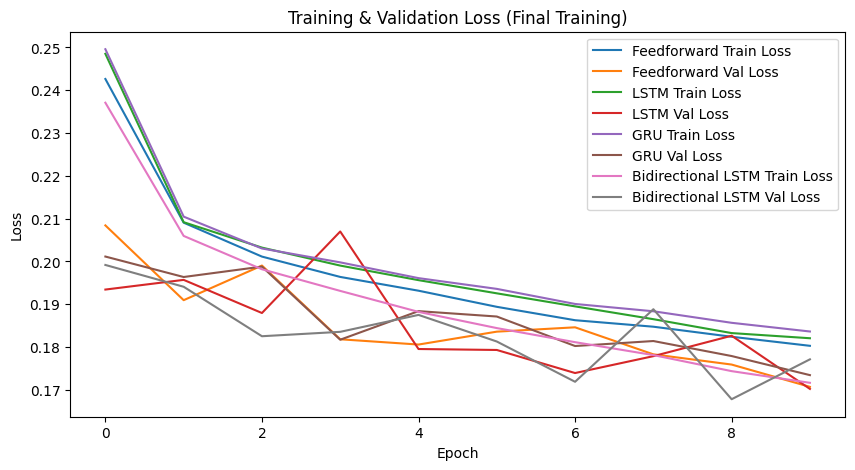

In [17]:
plt.figure(figsize=(10, 5))
for model_name, info in final_results.items():
    hist = info['history']
    if 'loss' in hist and 'val_loss' in hist:
        plt.plot(hist['loss'], label=f'{model_name} Train Loss')
        plt.plot(hist['val_loss'], label=f'{model_name} Val Loss')
plt.title('Training & Validation Loss (Final Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

C) Confusion Matrices (on Test Set)

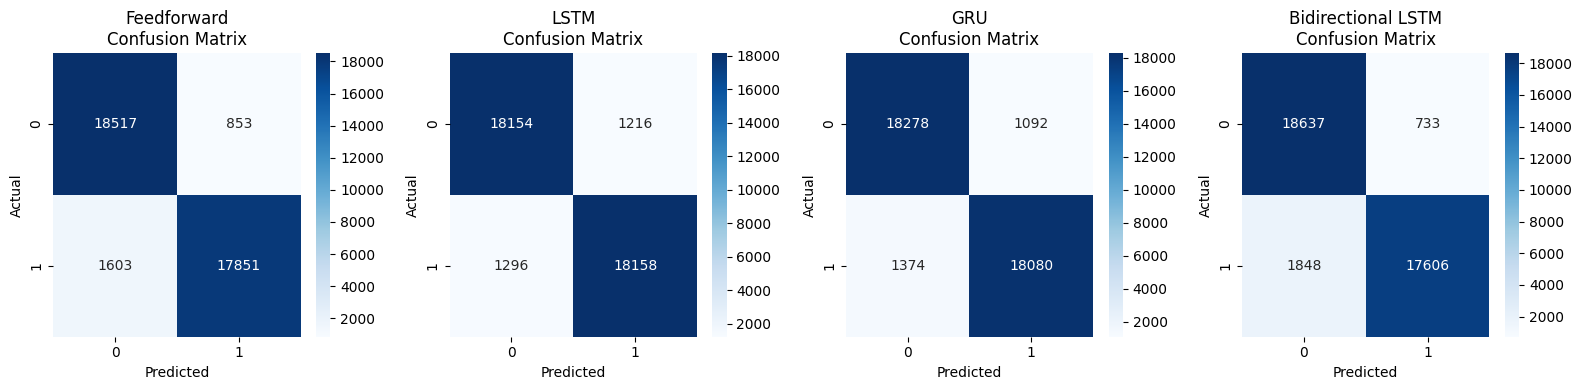

In [18]:
fig, axes = plt.subplots(1, len(final_results), figsize=(16, 4))
axes = axes.flatten()

for ax, (model_name, info) in zip(axes, final_results.items()):
    cm = confusion_matrix(y_test, info['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{model_name}\nConfusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

D) ROC Curves & AUC (on Test Set)

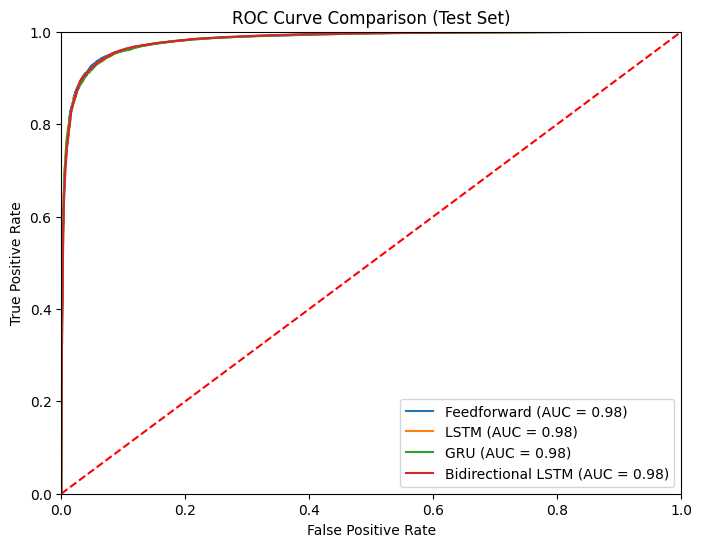

In [19]:
plt.figure(figsize=(8, 6))
for model_name, info in final_results.items():
    y_pred_proba = info['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--')  # random baseline
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Test Set)')
plt.legend()
plt.show()

# 9. Identify the Best Model Based on Test Accuracy

In [20]:
best_model_name = max(final_results, key=lambda m: final_results[m]['test_accuracy'])
best_acc = final_results[best_model_name]['test_accuracy']
print(f"\nBest model on Test Set: {best_model_name}")
print(f"Accuracy: {best_acc:.4f}")
print("Classification Report:")
print(final_results[best_model_name]['report'])

print("\nHyperparameters used for the best model:")
print(final_results[best_model_name]['hyperparams'])


Best model on Test Set: Feedforward
Accuracy: 0.9367
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94     19370
         1.0       0.95      0.92      0.94     19454

    accuracy                           0.94     38824
   macro avg       0.94      0.94      0.94     38824
weighted avg       0.94      0.94      0.94     38824


Hyperparameters used for the best model:
{'dense_units': 128, 'dropout': 0.3, 'lr': 0.001}


# 10. Save the Best Model and Architecture Info

In [21]:
best_model = final_results[best_model_name]['model']
best_model.save("best_model.h5")

# Save the best model architecture name (e.g., 'Feedforward' or 'LSTM')
with open("best_model_arch.txt", "w") as f:
    f.write(best_model_name)

print("\nBest model saved to best_model.h5")
print("Best model architecture saved to best_model_arch.txt")


Best model saved to best_model.h5
Best model architecture saved to best_model_arch.txt


# 11. Generating and Analyzing Sentiment-Based Comments

In [34]:
# Sample comments
comments = [
    "This is hands down the best product I've ever bought! Highly recommend!",
    "Completely dissatisfied, this was a huge mistake.",
    "Great value for money, surpassed my expectations!",
    "Waste of money, it doesn't do what it promised.",
    "Best purchase I've made in a long time!",
    "Absolutely terrible, don't waste your time or money.",
    "Highly recommend this, it exceeded all my expectations!"
]

# Extract embeddings
embeddings = get_roberta_embeddings(comments, batch_size=32, max_length=128)
print("Embeddings shape:", embeddings.shape)  # e.g. (num_samples, 768)

# Sentiment prediction
predictions = best_model.predict(embeddings)

# Map predictions to sentiment labels
for comment, pred in zip(comments, predictions):
    sentiment = 'Positive' if pred[0] > 0.5 else 'Negative'
    print(f"Comment: {comment}\nSentiment: {sentiment}\n")

Embeddings shape: (7, 768)
1/1 [==============================] - 0s 27ms/step
Comment: This is hands down the best product I've ever bought! Highly recommend!
Sentiment: Positive

Comment: Completely dissatisfied, this was a huge mistake.
Sentiment: Negative

Comment: Great value for money, surpassed my expectations!
Sentiment: Positive

Comment: Waste of money, it doesn't do what it promised.
Sentiment: Negative

Comment: Best purchase I've made in a long time!
Sentiment: Positive

Comment: Absolutely terrible, don't waste your time or money.
Sentiment: Negative

Comment: Highly recommend this, it exceeded all my expectations!
Sentiment: Positive

